# Monte Carlo random number generator using Weibull 2 and 3 parameters distribution

### Libraries and Exemple data

In [32]:
import numpy as np
import pandas as pd
import statistics
import math
import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import exponweib
from scipy.optimize import minimize
import numpy as np
from scipy.stats import chisquare
from scipy.stats import weibull_min


In [33]:
df = pd.read_csv("PdM_telemetry.csv")
vibro =df['vibration']

### Weilbull 2 parameters Random Number Generator

In [34]:
# Creating a function to find scale and shape parameters for Weibull 2 parameters distribution
def fitweibull2(x):
    logx = np.log(x)
    shape_guess = 1.2 / np.std(logx)
    scale_guess = np.exp(np.mean(logx) + (0.572 / shape_guess))
    initial_guess = [shape_guess, scale_guess]

    def optfun(theta):
        return -np.sum(np.log(exponweib.pdf(x, 1, theta[0], scale=theta[1], loc=0)))

    bounds = [(0, None), (0, None)]  # Bounds for shape and scale parameters
    result = minimize(optfun, initial_guess, method='SLSQP', bounds=bounds, tol=0.01)
    return result.x

In [35]:
# Creating a function to random generate numbers using Weibull 2 parameters distribution
def weinbull2_rand(data, loops, size=None):
    shape, scale = fitweibull2(data)
    
    if size == 1 or size is None:
        Xs = scale*(np.power(-np.log(1-np.random.uniform(0, 1, loops)), (1/shape)))
        X = np.mean(Xs)
        return X
    else:
        X_list = []
        for _ in range(size):
            Xs = scale*(np.power(-np.log(1-np.random.uniform(0, 1, loops)), (1/shape)))
            X_list.append(np.mean(Xs))
        return X_list

In [36]:
X = weinbull2_rand(vibro, 1000, 5000)
print(f'mean original: {np.mean(vibro)}')
print(f'mean generation: {np.mean(X)}')

mean original: 40.38500676114474
mean generation: 40.16745948446149


### Weilbull 3 parameters Random Number Generator

In [37]:
# Creating a function to find scale, shape and location parameters for Weibull 3 parameters distribution

def fitweibull3(x):
    logx = np.log(x)
    shape_guess = 1.2 / np.std(logx)
    scale_guess = np.exp(np.mean(logx) + (0.572 / shape_guess))
    loc_guess = np.min(x)  # Initial guess for the location parameter
    initial_guess = [shape_guess, scale_guess, loc_guess]

    def optfun(theta):
        return -np.sum(np.log(exponweib.pdf(x, 1, theta[0], scale=theta[1], loc=theta[2])))

    bounds = [(0, None), (0, None), (None, None)]  # Bounds for shape, scale, and loc parameters
    result = minimize(optfun, initial_guess, method='SLSQP', bounds=bounds, tol=0.01)
    return result.x

In [38]:
# Creating a function to random generate numbers using Weibull 3 parameters distribution
def weinbull3_rand(data, loops, size=None):
    shape, scale, location = fitweibull3(data)
       
    if size == 1 or size is None:
        Xs = scale*(np.power(-np.log(1-np.random.uniform(0, 1, loops)), (1/shape))) + location
        X = np.mean(Xs)
        return X
    else:
        X_list = []
        for _ in range(size):
            Xs = scale*(np.power(-np.log(1-np.random.uniform(0, 1, loops)), (1/shape)))
            X_list.append(np.mean(Xs))
        return X_list

### Comparing Results

In [39]:
np.random.seed(42)  # Set the seed value

#### Comparing Weibull 2 parameters results

In [40]:
# Calculating results of the implemented for 100 interactions loop and 10000 values generated
X_imp = weinbull2_rand(vibro, 100, 10000)

In [41]:
# Calculating results of scipy.stats module's weibull_min and weibull_min.fit functions for 10000 values generated
shap, loc, scal = stats.weibull_min.fit(vibro)
X_sci = weibull_min.rvs(shap, scale=scal, size=10000)

In [42]:
# Calculating results of scipy.stats module's weibull_min function and implemented parameter searching for 10000 values generated
shape, scale = fitweibull2(vibro)
X_impsci = weibull_min.rvs(shape, scale=scale, size=10000)

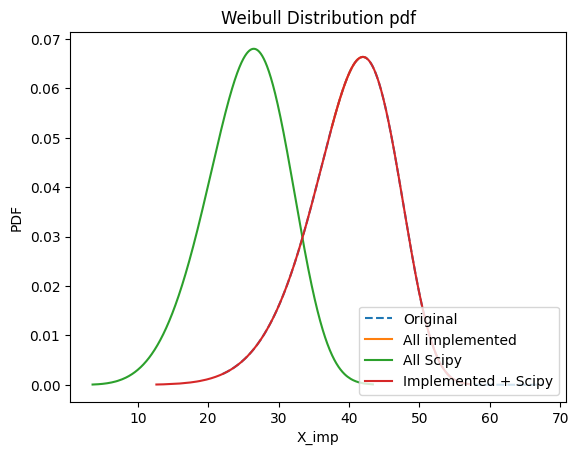

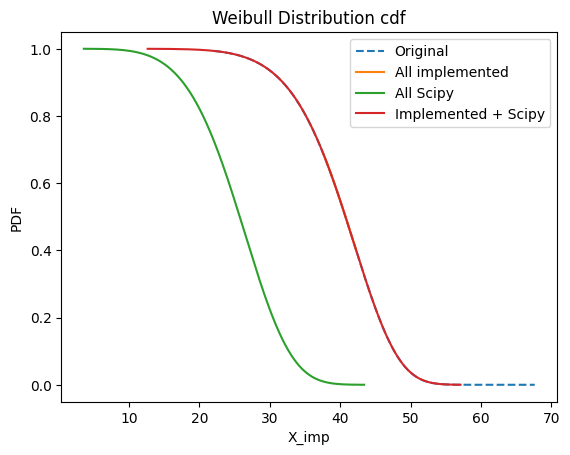

In [43]:
# Plotting PDF
pdf_original = (shape/scale)*np.power((np.sort(vibro[:10000])/scale),(shape-1))*np.exp(-np.power((np.sort(vibro[:10000])/scale),(shape)))
pdf_imp = (shape/scale)*np.power((np.sort(X_imp)/scale),(shape-1))*np.exp(-np.power((np.sort(X_imp)/scale),(shape)))
pdf_sci = (shap/scal)*np.power((np.sort(X_sci)/scal),(shap-1))*np.exp(-np.power((np.sort(X_sci)/scal),(shap)))
pdf_impsci = (shape/scale)*np.power((np.sort(X_impsci)/scale),(shape-1))*np.exp(-np.power((np.sort(X_impsci)/scale),(shape)))

plt.plot(np.sort(vibro[:10000]), pdf_original,linestyle = "--", label = "Original")
plt.plot(np.sort(X_imp), pdf_imp, label = "All implemented")
plt.plot(np.sort(X_sci), pdf_sci, label = "All Scipy")
plt.plot(np.sort(X_impsci), pdf_impsci, label = "Implemented + Scipy")
plt.legend()
plt.xlabel('X_imp')
plt.ylabel('PDF')
plt.title('Weibull Distribution pdf')

plt.show()

# Plotting CDF
cdf_original = np.exp(-np.power((np.sort(vibro[:10000])/scale),(shape)))
cdf_imp = np.exp(-np.power((np.sort(X_imp)/scale),(shape)))
cdf_sci = np.exp(-np.power((np.sort(X_sci)/scal),(shap)))
cdf_impsci = np.exp(-np.power((np.sort(X_impsci)/scale),(shape)))
plt.plot(np.sort(vibro[:10000]), cdf_original,linestyle = "--", label = "Original")
plt.plot(np.sort(X_imp), cdf_imp, label = "All implemented")
plt.plot(np.sort(X_sci), cdf_sci, label = "All Scipy")
plt.plot(np.sort(X_impsci), cdf_impsci, label = "Implemented + Scipy")
plt.legend()
plt.xlabel('X_imp')
plt.ylabel('PDF')
plt.title('Weibull Distribution cdf')

plt.show()

In [44]:
# Comparing results 10000 generated values

compare_df_weibull_2 = pd.DataFrame({
    'Approach': ['Original', 'Implemented search parameters and random generate numbers', 'Scipy for find parameters and random generate numbers', 'Implemented search parameters and Scipy for random generate numbers'],
    'Mean Result': [np.mean(vibro.loc[:10000]), np.mean(X_imp), np.mean(X_sci), np.mean(X_impsci)],
    'Time taken': [None,'4.3s','15.9s', '4.1s']
})
compare_df_weibull_2['Approach'].str.wrap(100)
compare_df_weibull_2

,Approach,Mean Result,Time taken
0,Original,40.576529,None
1,Implemented search parameters and random gener...,40.177564,4.3s
2,Scipy for find parameters and random generate ...,25.426299,15.9s
3,Implemented search parameters and Scipy for ra...,40.208133,4.1s


In [45]:
# Calculating results of the implemented for 100 interactions loop and 876100 values generated
X_imp = weinbull2_rand(vibro, 100, len(vibro))

In [46]:
# Calculating results of scipy.stats module's weibull_min and weibull_min.fit functions for 876100 values generated
shap, loc, scal = stats.weibull_min.fit(vibro)
X_sci = weibull_min.rvs(shap, scale=scal, size=len(vibro))

In [47]:
# Calculating results of scipy.stats module's weibull_min function and implemented parameter searching for 10000 values generated
shape, scale = fitweibull2(vibro)
X_impsci = weibull_min.rvs(shape, scale=scale, size=len(vibro))

c:\Users\airto\anaconda3\envs\yourenvname\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


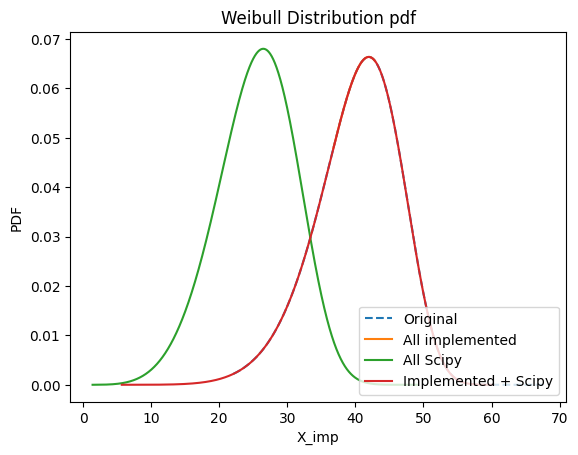

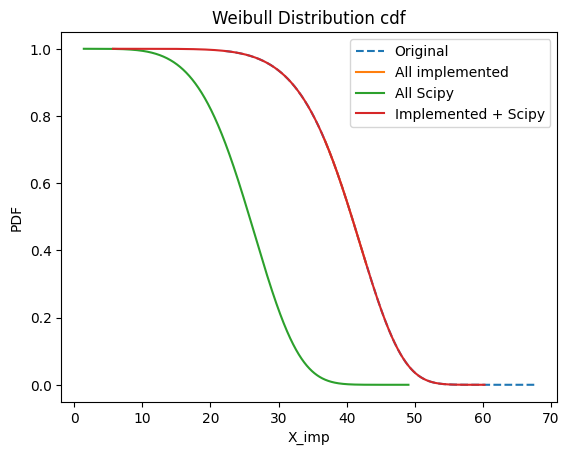

In [48]:
# Plotting PDF
pdf_original = (shape/scale)*np.power((np.sort(vibro[:10000])/scale),(shape-1))*np.exp(-np.power((np.sort(vibro[:10000])/scale),(shape)))
pdf_imp = (shape/scale)*np.power((np.sort(X_imp)/scale),(shape-1))*np.exp(-np.power((np.sort(X_imp)/scale),(shape)))
pdf_sci = (shap/scal)*np.power((np.sort(X_sci)/scal),(shap-1))*np.exp(-np.power((np.sort(X_sci)/scal),(shap)))
pdf_impsci = (shape/scale)*np.power((np.sort(X_impsci)/scale),(shape-1))*np.exp(-np.power((np.sort(X_impsci)/scale),(shape)))

plt.plot(np.sort(vibro[:10000]), pdf_original,linestyle = "--", label = "Original")
plt.plot(np.sort(X_imp), pdf_imp, label = "All implemented")
plt.plot(np.sort(X_sci), pdf_sci, label = "All Scipy")
plt.plot(np.sort(X_impsci), pdf_impsci, label = "Implemented + Scipy")
plt.legend()
plt.xlabel('X_imp')
plt.ylabel('PDF')
plt.title('Weibull Distribution pdf')

plt.show()

# Plotting CDF
cdf_original = np.exp(-np.power((np.sort(vibro[:10000])/scale),(shape)))
cdf_imp = np.exp(-np.power((np.sort(X_imp)/scale),(shape)))
cdf_sci = np.exp(-np.power((np.sort(X_sci)/scal),(shap)))
cdf_impsci = np.exp(-np.power((np.sort(X_impsci)/scale),(shape)))
plt.plot(np.sort(vibro[:10000]), cdf_original,linestyle = "--", label = "Original")
plt.plot(np.sort(X_imp), cdf_imp, label = "All implemented")
plt.plot(np.sort(X_sci), cdf_sci, label = "All Scipy")
plt.plot(np.sort(X_impsci), cdf_impsci, label = "Implemented + Scipy")
plt.legend()
plt.xlabel('X_imp')
plt.ylabel('PDF')
plt.title('Weibull Distribution cdf')

plt.show()

In [49]:
# Comparing results 876100 generated values

compare_df_weibull_2 = pd.DataFrame({
    'Approach': ['Original', 'Implemented search parameters and random generate numbers', 'Scipy for find parameters and random generate numbers', 'Implemented search parameters and Scipy for random generate numbers'],
    'Mean Result': [np.mean(vibro), np.mean(X_imp), np.mean(X_sci), np.mean(X_impsci)],
    'Time taken': [None,'33.2s','16.0s', '4.4s']
})
compare_df_weibull_2['Approach'].str.wrap(100)
compare_df_weibull_2

,Approach,Mean Result,Time taken
0,Original,40.385007,None
1,Implemented search parameters and random gener...,40.168453,33.2s
2,Scipy for find parameters and random generate ...,25.411576,16.0s
3,Implemented search parameters and Scipy for ra...,40.177392,4.4s


#### Comparing Weibull 3 parameters results

In [50]:
# Calculating results of the implemented for 100 interactions loop and 10000 values generated
X_imp = weinbull3_rand(vibro, 100, 10000)

C:\Users\airto\AppData\Local\Temp\ipykernel_3392\358067470.py:11: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(exponweib.pdf(x, 1, theta[0], scale=theta[1], loc=theta[2])))
c:\Users\airto\anaconda3\envs\yourenvname\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [51]:
# Calculating results of scipy.stats module's weibull_min and weibull_min.fit functions for 10000 values generated
shap, loc, scal = stats.weibull_min.fit(vibro)
X_sci = weibull_min.rvs(shap, loc = loc, scale=scal, size=10000)

In [52]:
# Calculating results of scipy.stats module's weibull_min function and implemented parameter searching for 10000 values generated
shape, scale, location = fitweibull3(vibro)
X_impsci = weibull_min.rvs(shape, loc=location, scale=scale, size=10000)

C:\Users\airto\AppData\Local\Temp\ipykernel_3392\358067470.py:11: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(exponweib.pdf(x, 1, theta[0], scale=theta[1], loc=theta[2])))


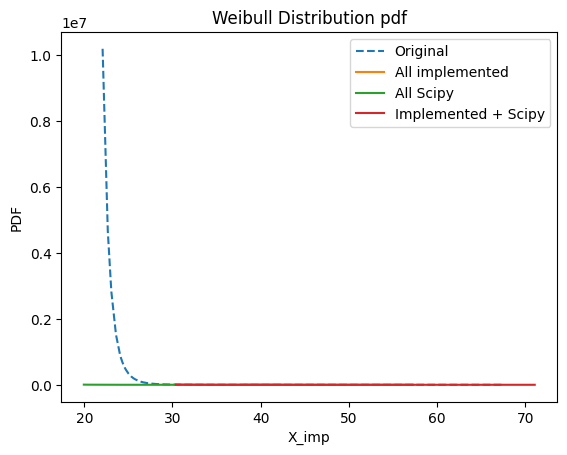

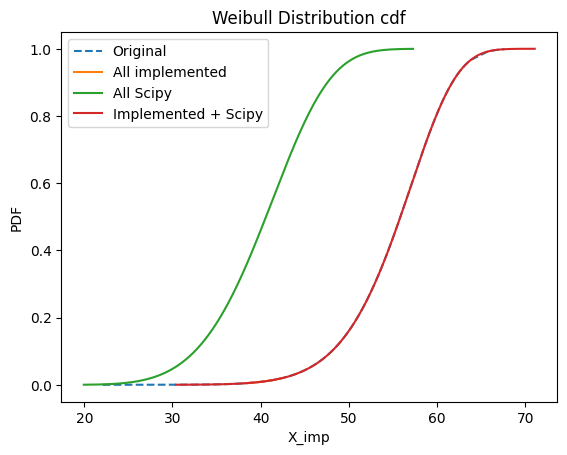

In [53]:
# Plotting PDF
pdf_original = (shape/scale)*np.power(((np.sort(vibro[:10000])-location)/scale),(-shape-1))*np.exp(-np.power(((np.sort(vibro[:10000])-location)/scale),(shape)))
pdf_imp = (shape/scale)*np.power(((np.sort(X_imp)-location)/scale),(-shape-1))*np.exp(-np.power(((np.sort(X_imp)-location)/scale),(shape)))
pdf_sci = (shap/scal)*np.power(((np.sort(X_sci)-loc)/scal),(-shap-1))*np.exp(-np.power(((np.sort(X_sci)-loc)/scal),(shap)))
pdf_impsci = (shape/scale)*np.power(((np.sort(X_impsci)-location)/scale),(-shape-1))*np.exp(-np.power(((np.sort(X_impsci)-location)/scale),(shape)))

plt.plot(np.sort(vibro[:10000]), pdf_original,linestyle = "--", label = "Original")
plt.plot(np.sort(X_imp), pdf_imp, label = "All implemented")
plt.plot(np.sort(X_sci), pdf_sci, label = "All Scipy")
plt.plot(np.sort(X_impsci), pdf_impsci, label = "Implemented + Scipy")
plt.legend()
plt.xlabel('X_imp')
plt.ylabel('PDF')
plt.title('Weibull Distribution pdf')

plt.show()

# Plotting CDF
cdf_original = 1-np.exp(-np.power(((np.sort(vibro[:10000])-location)/scale),(shape)))
cdf_imp = 1-np.exp(-np.power(((np.sort(X_imp)-location)/scale),(shape)))
cdf_sci = 1-np.exp(-np.power(((np.sort(X_sci)-loc)/scal),(shap)))
cdf_impsci = 1-np.exp(-np.power(((np.sort(X_impsci)-location)/scale),(shape)))

plt.plot(np.sort(vibro[:10000]), cdf_original,linestyle = "--", label = "Original")
plt.plot(np.sort(X_imp), cdf_imp, label = "All implemented")
plt.plot(np.sort(X_sci), cdf_sci, label = "All Scipy")
plt.plot(np.sort(X_impsci), cdf_impsci, label = "Implemented + Scipy")
plt.legend()
plt.xlabel('X_imp')
plt.ylabel('PDF')
plt.title('Weibull Distribution cdf')

plt.show()

In [54]:
# Comparing results 10000 generated values

compare_df_weibull_3 = pd.DataFrame({
    'Approach': ['Original', 'Implemented search parameters and random generate numbers', 'Scipy for find parameters and random generate numbers', 'Implemented search parameters and Scipy for random generate numbers'],
    'Mean Result': [np.mean(vibro.loc[:10000]), np.mean(X_imp), np.mean(X_sci), np.mean(X_impsci)],
    'Time taken': [None,'0.9s','16.7s', '0.6s']
})
compare_df_weibull_3['Approach'].str.wrap(100)
compare_df_weibull_3

,Approach,Mean Result,Time taken
0,Original,40.576529,None
1,Implemented search parameters and random gener...,40.392339,0.9s
2,Scipy for find parameters and random generate ...,40.256278,16.7s
3,Implemented search parameters and Scipy for ra...,55.337608,0.6s


In [55]:
# Calculating results of the implemented for 100 interactions loop and 876100 values generated
X_imp = weinbull3_rand(vibro, 100, len(vibro))

C:\Users\airto\AppData\Local\Temp\ipykernel_3392\358067470.py:11: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(exponweib.pdf(x, 1, theta[0], scale=theta[1], loc=theta[2])))
c:\Users\airto\anaconda3\envs\yourenvname\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [56]:
# Calculating results of scipy.stats module's weibull_min and weibull_min.fit functions for 876100 values generated
shap, loc, scal = stats.weibull_min.fit(vibro)
X_sci = weibull_min.rvs(shap, loc=loc, scale=scal, size=len(vibro))

In [57]:
# Calculating results of scipy.stats module's weibull_min function and implemented parameter searching for 10000 values generated
shape, scale, location = fitweibull3(vibro)
X_impsci = weibull_min.rvs(shape, loc=location, scale=scale, size=len(vibro))

C:\Users\airto\AppData\Local\Temp\ipykernel_3392\358067470.py:11: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(exponweib.pdf(x, 1, theta[0], scale=theta[1], loc=theta[2])))


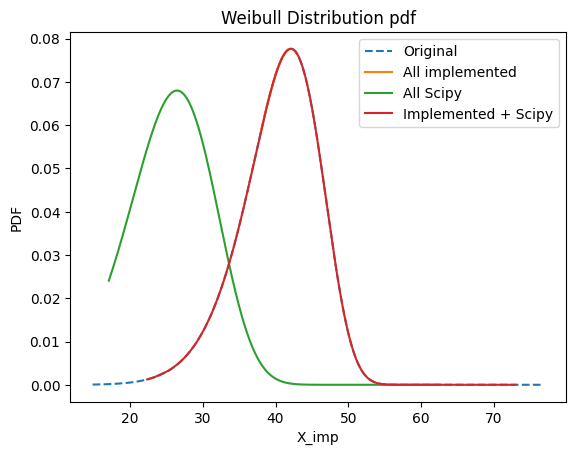

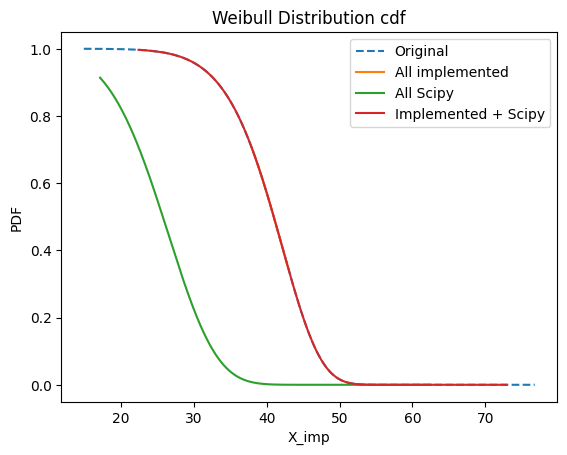

In [58]:
# Plotting PDF
pdf_original = (shape/scale)*np.power((np.sort(vibro)/scale),(shape-1))*np.exp(-np.power((np.sort(vibro)/scale),(shape)))
pdf_imp = (shape/scale)*np.power((np.sort(X_imp)/scale),(shape-1))*np.exp(-np.power((np.sort(X_imp)/scale),(shape)))
pdf_sci = (shap/scal)*np.power((np.sort(X_sci)/scal),(shap-1))*np.exp(-np.power((np.sort(X_sci)/scal),(shap)))
pdf_impsci = (shape/scale)*np.power((np.sort(X_impsci)/scale),(shape-1))*np.exp(-np.power((np.sort(X_impsci)/scale),(shape)))

plt.plot(np.sort(vibro), pdf_original,linestyle = "--", label = "Original")
plt.plot(np.sort(X_imp), pdf_imp, label = "All implemented")
plt.plot(np.sort(X_sci), pdf_sci, label = "All Scipy")
plt.plot(np.sort(X_impsci), pdf_impsci, label = "Implemented + Scipy")
plt.legend()
plt.xlabel('X_imp')
plt.ylabel('PDF')
plt.title('Weibull Distribution pdf')

plt.show()

# Plotting CDF
cdf_original = np.exp(-np.power((np.sort(vibro)/scale),(shape)))
cdf_imp = np.exp(-np.power((np.sort(X_imp)/scale),(shape)))
cdf_sci = np.exp(-np.power((np.sort(X_sci)/scal),(shap)))
cdf_impsci = np.exp(-np.power((np.sort(X_impsci)/scale),(shape)))
plt.plot(np.sort(vibro), cdf_original,linestyle = "--", label = "Original")
plt.plot(np.sort(X_imp), cdf_imp, label = "All implemented")
plt.plot(np.sort(X_sci), cdf_sci, label = "All Scipy")
plt.plot(np.sort(X_impsci), cdf_impsci, label = "Implemented + Scipy")
plt.legend()
plt.xlabel('X_imp')
plt.ylabel('PDF')
plt.title('Weibull Distribution cdf')

plt.show()

In [59]:
# Comparing results 10000 generated values

compare_df_weibull_3 = pd.DataFrame({
    'Approach': ['Original', 'Implemented search parameters and random generate numbers', 'Scipy for find parameters and random generate numbers', 'Implemented search parameters and Scipy for random generate numbers'],
    'Mean Result': [np.mean(vibro.loc[:10000]), np.mean(X_imp), np.mean(X_sci), np.mean(X_impsci)],
    'Time taken': [None,'26.7s','15.4s', '0.6s']
})
compare_df_weibull_3['Approach'].str.wrap(100)
compare_df_weibull_3

,Approach,Mean Result,Time taken
0,Original,40.576529,None
1,Implemented search parameters and random gener...,40.396041,26.7s
2,Scipy for find parameters and random generate ...,40.288562,15.4s
3,Implemented search parameters and Scipy for ra...,55.273046,0.6s


### Conclusions

- A code for Monte Carlo simulation was implemented that uses the inverse cumulative distribution of the 2-parameter and 3-parameter Weibull distribution to generate random numbers. For this, a code was jointly developed to localize the parameters of scale, shape and location.

-  The codes were developed to present two main differences in relation to the scipy module's weibull_min function (used to generate random numbers) and stats.weibull_min.fit (used to find the parameters given a set of data):
    - Greater precision, when performing an internal loop of interactions to generate a value based on the averages, and thus generate a set of numbers of the desired size, in addition to presenting greater precision to find the parameters of the Weibull distributions.
    - Shorter calculation time.

- The code implemented to find the scale, shape and location parameters showed good results, and can be implemented both with the random number generators implemented in this study, and with libraries and functions already known as scipy.stats module's weibull_min function. Showing even better results stats.weibull_min.fit.

- In the tests, the metrics evaluated were the proximity of the results to the original value of a data set of vibration values of a machine. Where three combinations were evaluated.
    - 1st Combination: Implemented parameter search code and random number generation code.
    - 2nd Combination: stats.weibull_min.fit for parameter search and weibull_min function for random number generation.
    - 3rd Combination: Implemented parameter search code and weibull_min function for generating random numbers.

    - In the tests for the 2-parameter Weibull, the 1st Combination presented results with greater precision, but the 3rd combination obtained very close results, with a better execution time, both also with results with very low difference in relation to the original values. The 2nd combination obtained values far from the original with high execution time.

    - In the tests for the 3-parameter Weibull, the 1st Combination presented results with greater precision, the 3rd presented a better execution time, but with a certain distance from the original values. The 2nd combination obtained values far from the original with high execution time.

    - The choice of combination and which of the Weibull distribution types and code combinations is dependent on the situation, however, for the tests carried out, the 2nd combination presents the best combination of precision and time.